# Lab 3 - Naive Bayes and KNN
Here, we are going to analyse two models: Naive Bayes and KNN

Observation: to test them, it's going to be used **k fold cross-validation** with repetition (RepeatedStratifiedKFold), because of the low number of records of the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
import sklearn.metrics as metrics
import itertools
import matplotlib.pyplot as plt

In [2]:
data: pd.DataFrame = pd.read_csv('datasets/pd_data_preparation.csv', sep=',', decimal='.', index_col='id')
y: np.ndarray = data.pop('class').values
X: np.ndarray = data.values
labels = pd.unique(y)

data.head()

,gender,PPE,DFA,RPDE,numPulses,stdDevPeriodPulses,locPctJitter,locShimmer,meanAutoCorrHarmonicity,minIntensity,...,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_30
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.916232,0.475707,0.590235,0.284974,0.022323,0.075900,0.271284,0.944323,0.692855,...,0.075621,0.300582,0.105270,0.013066,0.004055,0.003293,0.000374,0.000178,0.000191,0.098628
1,0.0,0.182314,0.806469,0.630075,0.242228,0.689703,0.247423,0.228818,0.876238,0.882924,...,0.072430,0.077755,0.174381,0.038398,0.008310,0.001114,0.001689,0.024783,0.018258,0.040204
2,1.0,0.877689,0.216841,0.516437,0.448187,0.033848,0.087255,0.117413,0.974092,0.871010,...,0.147429,0.038159,0.013139,0.007834,0.019385,0.000201,0.000368,0.000336,0.213153,0.120303
3,0.0,0.925807,0.237611,0.542708,0.785622,0.010547,0.021814,0.161006,0.983185,0.781731,...,0.016141,0.161223,0.097629,0.037870,0.020783,0.009404,0.018881,0.003916,0.000815,0.009216
4,0.0,0.930451,0.757013,0.842307,0.532383,0.754983,0.148962,0.722861,0.734980,0.497109,...,0.142211,0.230036,0.117364,0.022389,0.009184,0.006695,0.009538,0.010617,0.013877,0.010267


## Naive Bayes
Using Z normalization can help a little

In [3]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

CMAP = plt.cm.Blues

def plot_confusion_matrix(ax: plt.Axes, cnf_matrix: np.ndarray, classes_names: list, normalize: bool = False, title_complement = ''):
    if normalize:
        total = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / total
        title = 'Normalized confusion matrix ' + title_complement
    else:
        cm = cnf_matrix
        title = 'Confusion matrix ' + title_complement
    np.set_printoptions(precision=2)
    tick_marks = np.arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cm, interpolation='nearest', cmap=CMAP)

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), horizontalalignment="center")

Accuracy for: GaussianNB : 0.7828
Sensitivity for: GaussianNB : 0.7199


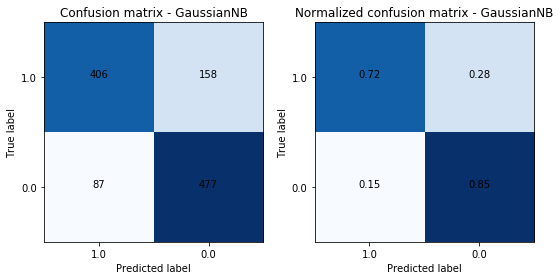

Accuracy for: MultinomialNB : 0.7349
Sensitivity for: MultinomialNB : 0.7518


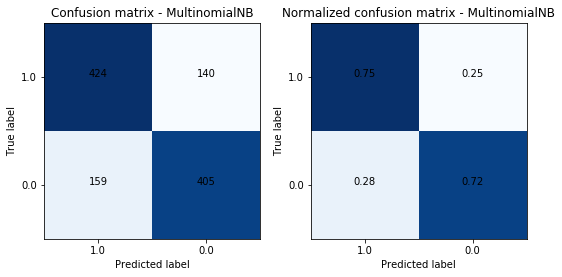

Accuracy for: BernoulyNB : 0.5390
Sensitivity for: BernoulyNB : 0.3670


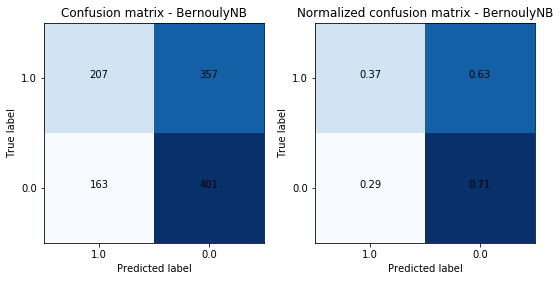

In [11]:
estimators = {'GaussianNB': GaussianNB(), 
              'MultinomialNB': MultinomialNB(), 
              'BernoulyNB': BernoulliNB()}

#todo: review names variables and code
accuracy = {}
sensitivity = {}
cnf_mtx = {}
for clf in estimators:
    accuracy[clf] = 0
    sensitivity[clf] = 0
    cnf_mtx[clf] = np.zeros((2, 2)).astype(int)

n_splits = 4
n_repeats = 3

rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for clf in estimators:
        estimators[clf].fit(X_train, y_train)
        prdY = estimators[clf].predict(X_test)
        accuracy[clf] += metrics.accuracy_score(y_test, prdY)
        sensitivity[clf] += metrics.recall_score(y_test, prdY)
        cnf_mtx[clf] += metrics.confusion_matrix(y_test, prdY, labels)
for clf in estimators:
    accuracy[clf] /= n_splits*n_repeats
    sensitivity[clf] /= n_splits*n_repeats
    print("Accuracy for:", clf, ':', format(accuracy[clf], '.4f'))
    print("Sensitivity for:", clf, ':', format(sensitivity[clf], '.4f'))
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
    plot_confusion_matrix(axs[0, 0], cnf_mtx[clf], labels, title_complement=('- ' + clf))
    plot_confusion_matrix(axs[0, 1], cnf_mtx[clf], labels, normalize=True, title_complement=('- ' + clf))
    plt.tight_layout()
    plt.show()

So, we can use the Gaussian Naive Bayes (with 4 folds and 3 repetitions) as our baseline, with accuracy around 0,7828.

## KNN
We can try use weights as well

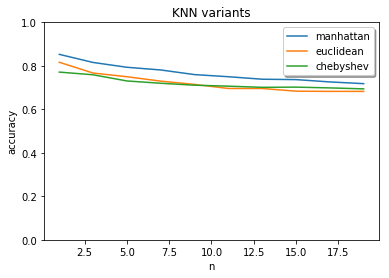

In [5]:
from sklearn.neighbors import KNeighborsClassifier

def multiple_line_chart(ax: plt.Axes, xvalues: list, yvalues: dict, title: str, xlabel: str, ylabel: str, percentage=False):
    legend: list = []
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)

    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
    ax.legend(legend, loc='best', fancybox = True, shadow = True)

n_splits = 4
n_repeats = 3
nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
recall = {}
for d in dist:
    values[d] = np.zeros(len(nvalues))
    recall[d] = np.zeros(len(nvalues))

rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for d in dist:
        yvalues = []
        recall_values = []
        for n in nvalues:
            knn = KNeighborsClassifier(n_neighbors=n, metric=d)
            knn.fit(X_train, y_train)
            prdY = knn.predict(X_test)
            yvalues.append(metrics.accuracy_score(y_test, prdY))
            recall_values.append(metrics.recall_score(y_test, prdY))
        values[d] += yvalues
        recall[d] += recall_values
for d in dist:
    values[d] /= (n_splits*n_repeats)
    recall[d] /= (n_splits*n_repeats)
plt.figure()
multiple_line_chart(plt.gca(), nvalues, values, 'KNN variants', 'n', 'accuracy', percentage=True)
plt.show()

Manhattan distance resulted in the best accuracy, especially with lower numbers of neighbours.

In [6]:
for aux in range(len(values['manhattan'])):
    print('Accuracy for n equal to', nvalues[aux], ':', format(values['manhattan'][aux], '.4f'))
    print('Sensitivity for n equal to', nvalues[aux], ':', format(recall['manhattan'][aux], '.4f'), '\n')

Accuracy for n equal to 1 : 0.8528
Sensitivity for n equal to 1 : 0.7252 

Accuracy for n equal to 3 : 0.8156
Sensitivity for n equal to 3 : 0.6667 

Accuracy for n equal to 5 : 0.7934
Sensitivity for n equal to 5 : 0.6312 

Accuracy for n equal to 7 : 0.7810
Sensitivity for n equal to 7 : 0.5940 

Accuracy for n equal to 9 : 0.7598
Sensitivity for n equal to 9 : 0.5638 

Accuracy for n equal to 11 : 0.7500
Sensitivity for n equal to 11 : 0.5585 

Accuracy for n equal to 13 : 0.7385
Sensitivity for n equal to 13 : 0.5496 

Accuracy for n equal to 15 : 0.7367
Sensitivity for n equal to 15 : 0.5461 

Accuracy for n equal to 17 : 0.7261
Sensitivity for n equal to 17 : 0.5319 

Accuracy for n equal to 19 : 0.7181
Sensitivity for n equal to 19 : 0.5266 



KNN with K=1 may result in model too sensitive to outliers, so it may not be the best result. Having more features than records can be one problem, therefore it will be tested the accuracy if we use just the features used for the sparsity plots on 01_Data_exploration.

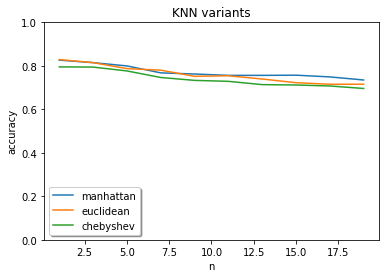

Accuracy for n equal to 1 : 0.8262
Sensitivity for n equal to 1 : 0.7447 

Accuracy for n equal to 3 : 0.8147
Sensitivity for n equal to 3 : 0.7394 

Accuracy for n equal to 5 : 0.7996
Sensitivity for n equal to 5 : 0.7216 

Accuracy for n equal to 7 : 0.7677
Sensitivity for n equal to 7 : 0.7074 

Accuracy for n equal to 9 : 0.7624
Sensitivity for n equal to 9 : 0.7092 

Accuracy for n equal to 11 : 0.7562
Sensitivity for n equal to 11 : 0.6968 

Accuracy for n equal to 13 : 0.7562
Sensitivity for n equal to 13 : 0.6986 

Accuracy for n equal to 15 : 0.7571
Sensitivity for n equal to 15 : 0.6879 

Accuracy for n equal to 17 : 0.7491
Sensitivity for n equal to 17 : 0.6667 

Accuracy for n equal to 19 : 0.7349
Sensitivity for n equal to 19 : 0.6525 



In [9]:
data_test: pd.DataFrame = pd.read_csv('datasets/pd_data_preparation.csv', sep=',', decimal='.', index_col='id')
data_test = data_test[['gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'locPctJitter', 'locShimmer', 'f1', 'mean_MFCC_2nd_coef', 'mean_MFCC_5th_coef', 'std_Log_energy', 'tqwt_energy_dec_17', 'class']]
y_2: np.ndarray = data_test.pop('class').values
X_2: np.ndarray = data_test.values

n_splits = 4
n_repeats = 3
nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
recall = {}
for d in dist:
    values[d] = np.zeros(len(nvalues))
    recall[d] = np.zeros(len(nvalues))

rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X_2[train_index], X_2[test_index]
    y_train, y_test = y_2[train_index], y_2[test_index]
    for d in dist:
        yvalues = []
        recall_values = []
        for n in nvalues:
            knn = KNeighborsClassifier(n_neighbors=n, metric=d)
            knn.fit(X_train, y_train)
            prdY = knn.predict(X_test)
            yvalues.append(metrics.accuracy_score(y_test, prdY))
            recall_values.append(metrics.recall_score(y_test, prdY))
        values[d] += yvalues
        recall[d] += recall_values
for d in dist:
    values[d] /= (n_splits*n_repeats)
    recall[d] /= (n_splits*n_repeats)
plt.figure()
multiple_line_chart(plt.gca(), nvalues, values, 'KNN variants', 'n', 'accuracy', percentage=True)
plt.show()

for aux in range(len(values['manhattan'])):
    print('Accuracy for n equal to', nvalues[aux], ':', format(values['manhattan'][aux], '.4f'))
    print('Sensitivity for n equal to', nvalues[aux], ':', format(recall['manhattan'][aux], '.4f'), '\n')

With these features, the accuracy is a little worse, but there is a gain on sensitivity, which is important for a medical problem, since we would rather get false positives than false negatives.

Another consideration: the K = 1 can indicate that each feature contribute a little to the result, then getting only the nearest neighbour results the best prediction in this case.